# Part 2: Feature engineering

Feature engineering is the process of identifying the most relevant features from the data and transforming them into a format suitable for a machine learning model.

In this section, we’ll first check if there’s a collinearity between numerical features and try to eliminate it because regression models like logistic regression are sensitive to it. Then, we need to transform all the numerical columns into a common scale. Second, all machine learning algorithms requires numerical input, therefore all categorical attributes in the dataset must be encoded into numerical labels.

In [1]:
# standard
import pandas as pd
import numpy as np
import math

# plots
import matplotlib.pyplot as plt

# data set path
data_path = "C:/Users/Sadek/Documents/GitHub/Project/telecom-customer-churn/data/"

In [2]:
# import telecom data set into a pandas data frame
df_telecom = pd.read_csv(data_path+"WA_Fn-UseC_-Telco-Customer-Churn.csv")

# correct object type
df_telecom["TotalCharges"] = pd.to_numeric(df_telecom["TotalCharges"], errors="coerce")

# drop observation with null values
df_telecom.dropna(inplace=True)

# drop customerID from the data set
df_telecom.drop(columns="customerID", inplace=True)

From the previous analysis, the different numerical features exhibit an important correlation coefficient with the target. \
Before introducing these features to the model, it is best to check the correlation between them and determine whether any of them exhibit collinearity or multicollinearity. Because this can pose a problem in many cases as you would normally want your independent variables to be… independent.

If collinearity or multicollinearity is left unchecked, it can raise the variance of coefficient estimates, leading to larger confidence intervals. This makes it more difficult to obtain statistically significant results from any subsequent analysis.

In short, collinearity or multicollinearity may not interfere with model performance, but it does negatively impact the interpretation of the predictors used to build the model.



# 1. Feature selection

## 1.1. Visualize the relationship between numerical features

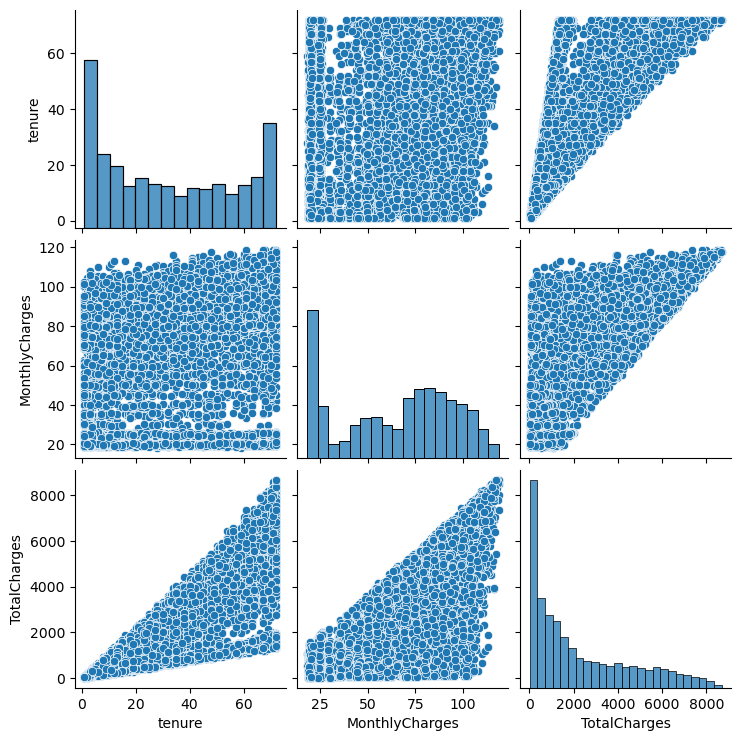

In [3]:
import seaborn as sns

numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.pairplot(df_telecom[numerical])
plt.show()

From the visualizations above, it is barely possible to identify if there is a relationship between the different features. \
For further analysis, we will check the correlation between each feature. The Pearson’s correlation coefficient metric directly evaluates the strength of the relationship between two variables. Its values range between -1 and 1.

## 1.2. Correlation Coefficient

Now, let’s compute the correlation coefficient values for each pair of numerical features.

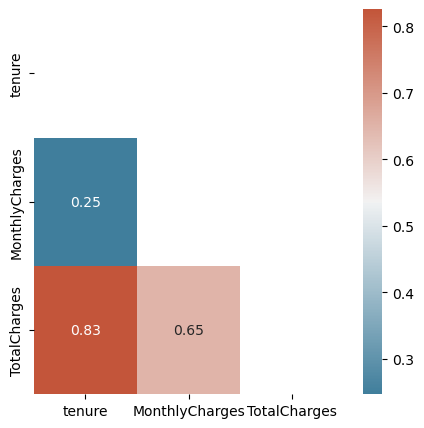

In [4]:
def correlation_heatmap(dataset):
    # Correlation between different variables
    corr = dataset.corr()
    # Set up the matplotlib plot configuration
    f, ax = plt.subplots(figsize=(5, 5))
    # Generate a mask for upper traingle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap
#     sns.heatmap(corr, cmap="Blues", annot=True,mask = mask)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
    plt.show()
    
correlation_heatmap(df_telecom[numerical])

From the above correlation matrix, we can identify a strong correlation between:
* `TotalCharges` and `tenure`
* `TotalCharges` and `MonthlyCharges`

But which of these feature should be excluded in order to fix collinearity or do we need to eliminate both of them to develop models with less overall variance?

The answer is no.

By intentionally eliminating features, you risk removing too much important information, which is detrimental to building a reliable model.

## 1.3. Variance inflation factor

While correlation matrix and scatter plots can be used to find collinearity, they only show the bivariate relationship between the independent variables.

**VIF**, on the other hand, allows you to determine the strength of the correlation between different independent variables. It's calculated by taking one variable and regressing it against all other variables.



The valid value for VIF ranges from 1 to infinity. A rule of thumb for interpreting VIF values is:
* VIF < 1 features are not correlated
* 1 < VIF < 5 — features are moderately correlated
* VIF > 5 — features are highly correlated
* VIF > 10 — high correlation between features and is cause for concern

In [5]:
from sklearn.linear_model import LinearRegression

def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [6]:
calculate_vif(df=df_telecom, features=['tenure', 'MonthlyCharges', 'TotalCharges'])

,VIF,Tolerance
tenure,5.844646,0.171097
MonthlyCharges,3.225293,0.310049
TotalCharges,9.526697,0.104968


Again, the rookie mistake would be to remove all features with VIF > 5 at once. Feature selection is usually best performed by including or removing one feature at a time. This ensures that any information loss is minimized.

Thus, the highly correlated feature will be removed and we will see if the VIF result improves. Let’s try removing `TotalCharges` since it has a higher VIF.

In [7]:
calculate_vif(df=df_telecom, features=['tenure', 'MonthlyCharges'])

,VIF,Tolerance
tenure,1.064896,0.939059
MonthlyCharges,1.064896,0.939059


As observed, removing `TotaleCharges` results in a lower VIF for all other features, are all within the acceptable range, the derived model will be more likely to yield statistically significant results.

# 2. Feature pre-processing
## 2.1. Numerical features
Data normalization is a common practice in ML, which consists of transforming numerical data into a common scale, **because the value of some features differs significantly from others features**. Features with higher values will dominate the learning process and it doesn’t mean that they’re more important for the prediction. Data normalization transforms multiscale data to the same scale in order to ensure that all variables have a similar influence, which in return will insure the stability if the model and improve its performance.

In [8]:
numerical_columns = ["tenure", "MonthlyCharges"]
df_telecom[numerical_columns].describe()

,tenure,MonthlyCharges
count,7032.000000,7032.000000
mean,32.421786,64.798208
std,24.545260,30.085974
min,1.000000,18.250000
25%,9.000000,35.587500
50%,29.000000,70.350000
75%,55.000000,89.862500
max,72.000000,118.750000


We see that the dataset’ features spam across different ranges. \
We'll transform the distribution of the various features to resemble standard normally distributed data (Gaussian with mean zero and unit variance).

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_telecom[numerical_columns])

data_scaled = pd.DataFrame(data_scaled, columns=numerical_columns)
data_scaled.describe()

,tenure,MonthlyCharges
count,7.032000e+03,7.032000e+03
mean,-1.214741e-16,9.652878e-17
std,1.000071e+00,1.000071e+00
min,-1.280248e+00,-1.547283e+00
25%,-9.542963e-01,-9.709769e-01
50%,-1.394171e-01,1.845440e-01
75%,9.199259e-01,8.331482e-01
max,1.612573e+00,1.793381e+00


After standardization, the mean of all columns is close to 0 and the standard deviation of both features is close to 1. \
We can also observe that StandardScaler **doesn’t change** the structure of the data, only the axes got shifted and scaled.

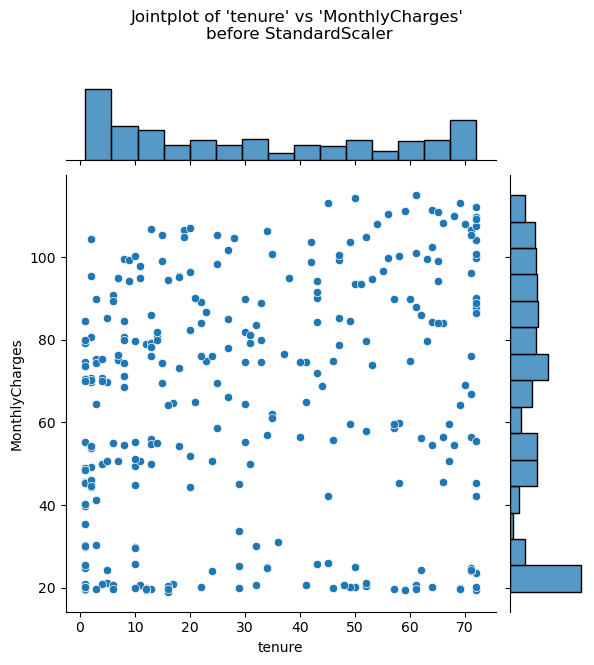

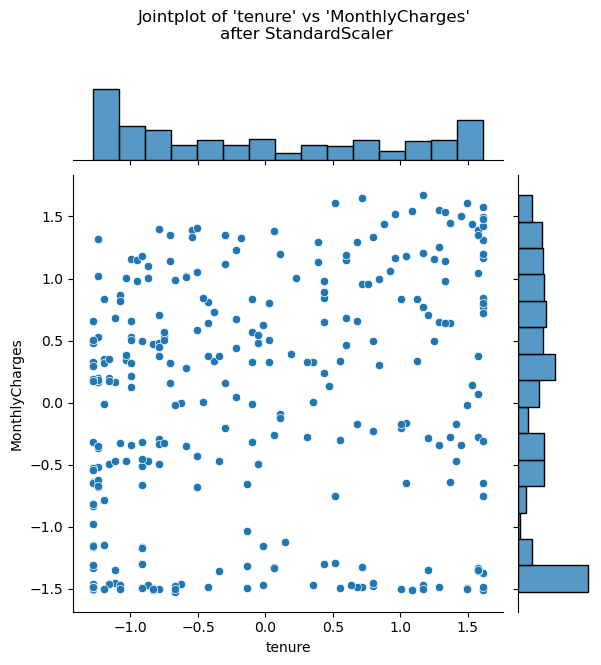

In [10]:
# number of points to visualize to have a clearer plot
num_points_to_plot = 300

sns.jointplot(data=df_telecom[numerical_columns][:num_points_to_plot], x="tenure",
              y="MonthlyCharges", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot of 'tenure' vs 'MonthlyCharges' \nbefore StandardScaler", y=1.1)

sns.jointplot(data=data_scaled[:num_points_to_plot], x="tenure",
              y="MonthlyCharges", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot of 'tenure' vs 'MonthlyCharges' \nafter StandardScaler", y=1.1)
plt.show()

## 2.2. Categorical features

In contrast, categorical variables have discrete values, typically represented by a string taken from a finite list of possible choices. As a ML model can only deal with numbers, categorical data need to be converted into a matrix form.

In [11]:
target_name = "Churn"
target = df_telecom[target_name]
data = df_telecom.drop(columns=[target_name, "gender", "TotalCharges"])

Here I used `make_column_selector`, which allows us to select columns based on their data type.

In [12]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

print(
    f"The dataset is composed of {len(categorical_columns)} categorical features")

for column in categorical_columns:
    print(f"Column: {column} - Unique values: {df_telecom[column].unique()}")

The dataset is composed of 14 categorical features
Column: Partner - Unique values: ['Yes' 'No']
Column: Dependents - Unique values: ['No' 'Yes']
Column: PhoneService - Unique values: ['No' 'Yes']
Column: MultipleLines - Unique values: ['No phone service' 'No' 'Yes']
Column: InternetService - Unique values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique values: ['No' 'Yes' 'No internet service']
Column: TechSupport - Unique values: ['No' 'Yes' 'No internet service']
Column: StreamingTV - Unique values: ['No' 'Yes' 'No internet service']
Column: StreamingMovies - Unique values: ['No' 'Yes' 'No internet service']
Column: Contract - Unique values: ['Month-to-month' 'One year' 'Two year']
Column: PaperlessBilling - Unique values: ['Yes' 'No']
Column: PaymentMethod - Unique values: ['Electronic check' 'Mailed check' 'Bank transfer 

Next, we will encode our data into a representative format using the `One-Hot Encoding` strategy.

In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
categorical_columns_encoded = encoder.fit_transform(df_telecom[categorical_columns])

In [14]:
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
categorical_columns_encoded = pd.DataFrame(categorical_columns_encoded, columns=feature_names)
categorical_columns_encoded.head(2)

,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
print(
    f"The encoded dataset contains {categorical_columns_encoded.shape[1]} features")

The encoded dataset contains 39 features


When having a categorical variable with many categories, the `drop` parameter is useful. It’ll reduce the encoded dimensionality and avoid collinearity.

file:///C:/Users/Sadek/OneDrive%20-%20ESPRIT/Project/DS/Machine%20learning%20in%20Python%20with%20scikit-learn/ML%20sklearn/inria.github.io/scikit-learn-mooc/python_scripts/linear_models_sol_04.html

In [16]:
encoder = OneHotEncoder(sparse=False, drop='first')
categorical_columns_encoded = encoder.fit_transform(df_telecom[categorical_columns])
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)

categorical_columns_encoded = pd.DataFrame(categorical_columns_encoded, columns=feature_names)
categorical_columns_encoded.head(2)

,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [17]:
print(
    f"The encoded dataset contains {categorical_columns_encoded.shape[1]} features")

The encoded dataset contains 25 features
